In [1]:
import numpy as np
import pandas as pd


In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
import re
import string
import missingno as msno
import nltk


In [3]:
from itertools import chain
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfVectorizer
import random
%matplotlib inline 

print("Libraries Imported")


Libraries Imported


In [4]:
DATASET_COLUMNS  = ["class_label", "id", "date", "flag", "userid", "tweet"]
DATASET_ENCODING = "ISO-8859-1"
p = 0.05
data = pd.read_csv('Tweet.data.training.1600000.processed.noemoticon.csv',
                      encoding=DATASET_ENCODING , names=DATASET_COLUMNS,
                  skiprows=lambda i: i>0 and random.random() > p)

data.head()

,class_label,id,date,flag,userid,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,@Tatiana_K nope they didn't have it
3,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,@twittera que me muera ?
4,0,1467812723,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,TLeC,@caregiving I couldn't bear to watch it. And ...


In [5]:
data.shape

(79767, 6)

In [6]:
data['class_label'] = data['class_label'].replace(4,1)
data.class_label.unique()


array([0, 1], dtype=int64)

[]

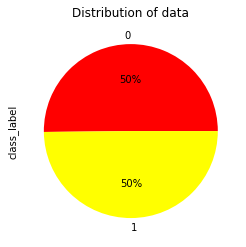

In [7]:
ax = data.class_label.value_counts().plot(kind='pie', title='Distribution of data',autopct='%1.0f%%', colors=["red","yellow"])
ax.plot()

In [8]:
print(data.isnull().sum())

class_label    0
id             0
date           0
flag           0
userid         0
tweet          0
dtype: int64


In [9]:
print(len(data.tweet))
print(len(data.tweet.unique()))

79767
79567


In [10]:
data.drop_duplicates(subset=['tweet', 'userid'],keep = False, inplace = True)

In [11]:
def remove_users_and_url(i):
    temp=" ".join(filter(lambda x:x[0]!='@', i.split())) 
    temp_1=re.sub(r"http\S+", "", temp)                       
    temp_2 =" ".join(filter(lambda x:x[0]!='&', temp_1.split()))  
    return temp_2

def replace_emoji(a):
    x1=a.replace(":‑)","happy")
    x2=x1.replace(";)","happy")
    x3=x2.replace(":-}","happy")
    x4=x3.replace(":)","happy")
    x5=x4.replace(":}","happy")
    x6=x5.replace("=]","happy")
    x7=x6.replace("=)","happy")
    x8=x7.replace(":D","happy")
    x9=x8.replace("xD","happy")
    x10=x9.replace("XD","happy")
    x11=x10.replace(":‑(","sad")    
    x12=x11.replace(":‑[","sad")
    x13=x12.replace(":(","sad")
    x14=x13.replace("=(","sad")
    x15=x14.replace("=/","sad")
    x16=x15.replace(":[","sad")
    x17=x16.replace(":{","sad")
  
    x18=x17.replace(":P","playful")
    x19=x18.replace("XP","playful")
    x20=x19.replace("xp","playful")
  
    
    x21=x20.replace("<3","love")
    x22=x21.replace(":o","shock")
    x23=x22.replace(":-/","sad")
    x24=x23.replace(":/","sad")
    x25=x24.replace(":|","sad")
    return x25

def decontract_words(phrase):
    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)   #using regular expressions to expand the contractions
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

def remove_digits(sentence):
    sent = re.sub('\w*\d\w*','', sentence)
    return sent
    
def to_lower_text(sentence):
    return sentence.lower()


stop_words = ["i", "me", "my", "myself", "we", "our","will", "go","got","ours", "ourselves", "you", "your", "yours", "yourself", "yourselves", "he",
      "him", "his", "himself", "she", "her", "hers", "herself", "it", "its", "itself", "they", "them", "their", "theirs", "themselves", "what",
      "which", "who", "whom", "this", "that", "these", "those", "am", "is", "are", "was", "were", "be", "been", "being", "have", "has", "had",
      "having", "do", "does", "did", "doing", "a", "an", "the", "and", "but", "if", "or", "because", "as", "until", "while", "of", "at", "by",
      "for", "with", "about", "against", "between", "into", "through", "during", "before", "after", "above", "below", "to", "from", "up", "down",
      "in", "out", "on", "off", "over", "under", "again", "further", "then", "once", "here", "there", "when", "where", "why", "how", "all", "any",
      "both", "each", "few", "more", "most", "other", "some", "such",  "nor", "only", "own", "same", "so", "than", "too", "very", "s", "t", "just",
      "don", "should", "now"]


def preprocess(data,stop_words):
    data["tweet"]=data["tweet"].apply(remove_users_and_url)
    data['tweet']=data['tweet'].apply(replace_emoji)
    data['tweet']=data['tweet'].apply(lambda x: to_lower_text(x))
    data['tweet']=data['tweet'].apply(lambda x: remove_digits(x))
    data["tweet"]=data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))
    data["tweet"]=data["tweet"].apply(lambda x: re.sub(' +', ' ', x))
    data['tweet']=data['tweet'].apply(lambda x: re.sub('[%s]' % re.escape(string.punctuation), '', x))
    data['tweet']=data['tweet'].apply(decontract_words)
    return data

In [12]:
%%time
data = preprocess(data,stop_words)

Wall time: 7.25 s


In [13]:
data.head()

,class_label,id,date,flag,userid,tweet
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,awww thats bummer shoulda david carr third da...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,upset cant update facebook texting it might cr...
2,0,1467811795,Mon Apr 06 22:20:05 PDT 2009,NO_QUERY,2Hood4Hollywood,nope didnt
3,0,1467812025,Mon Apr 06 22:20:09 PDT 2009,NO_QUERY,mimismo,que muera
4,0,1467812723,Mon Apr 06 22:20:19 PDT 2009,NO_QUERY,TLeC,couldnt bear watch it thought ua loss embarras...


In [14]:
X=data.drop(['class_label',"id","date","flag","userid"], axis = 1)
y=data["class_label"].values

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3,random_state=42)
vectorizer = TfidfVectorizer(analyzer = "word")
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features = 40000) 
vectorizer.fit( X_train['tweet'].values )
x_tr=vectorizer.transform(X_train['tweet'].values)
x_te=vectorizer.transform(X_test['tweet'].values)

In [16]:
X_train.head()

,tweet
20715,no credit lol
43798,mmm picture barry zito
72856,rp a ill today
70014,people not happy livesthat think pathetic keep...
19875,eh dong use tweet deck ah ngalih saja ku downl...


In [17]:
vectorizer = TfidfVectorizer(analyzer = "word") 
vectorizer = TfidfVectorizer(min_df=10,ngram_range=(1,3), max_features = 40000) 
vectorizer.fit(X_train['tweet'].values)
x_tr=vectorizer.transform(X_train['tweet'].values)
x_te=vectorizer.transform(X_test['tweet'].values)

In [18]:
x_tr.shape

(55781, 5957)

No handles with labels found to put in legend.


              precision    recall  f1-score   support

           0       0.74      0.77      0.76     11960
           1       0.76      0.73      0.75     11947

    accuracy                           0.75     23907
   macro avg       0.75      0.75      0.75     23907
weighted avg       0.75      0.75      0.75     23907



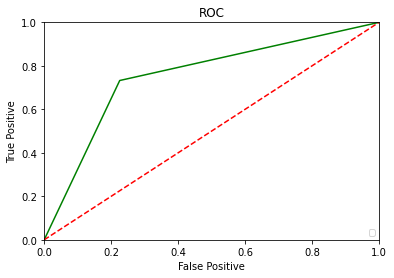

In [49]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report
count=0

mnb = MultinomialNB()
y_pred = mnb.fit(x_tr.toarray(), y_train).predict(x_te.toarray())
print(classification_report(y_test, y_pred))



import matplotlib.pyplot as plt
import scikitplot as skplt
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, "green" )
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.show()


No handles with labels found to put in legend.


              precision    recall  f1-score   support

           0       0.78      0.75      0.76     11960
           1       0.76      0.78      0.77     11947

    accuracy                           0.77     23907
   macro avg       0.77      0.77      0.77     23907
weighted avg       0.77      0.77      0.77     23907



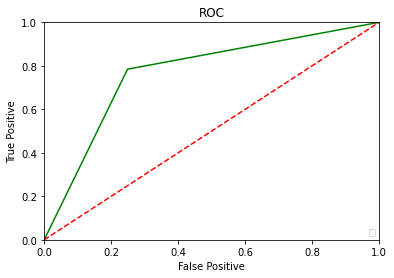

In [50]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import plot_confusion_matrix
from sklearn.svm import SVC


clf = SVC(kernel='linear', gamma = 'auto')
y_pred2 = clf.fit(x_tr, y_train).predict(x_te)

print(classification_report(y_test, y_pred2))


import matplotlib.pyplot as plt
import scikitplot as skplt
false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, y_pred2)
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('ROC')
plt.plot(false_positive_rate, true_positive_rate, "green" )
plt.legend(loc='lower right', prop={'size':8})
plt.plot([0,1],[0,1], color='red', linestyle='--')
plt.xlim([0.0,1.0])
plt.ylim([0.0,1.0])
plt.ylabel('True Positive')
plt.xlabel('False Positive')
plt.show()

